# Load Datasets

In [16]:
import numpy as np
import pandas as pd
import os

import sklearn.tree
import sklearn.ensemble

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [17]:
# Clone repository in order to get access locally to the datasets
!rm -rf .git README.md
!git clone -b playing-emsembled-methods https://github.com/sergio-gimenez/anomaly-4G-detection 

fatal: destination path 'anomaly-4G-detection' already exists and is not an empty directory.


In [18]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Jan 10 16:19 .
drwxr-xr-x 1 root root 4096 Jan 10 16:10 ..
drwxr-xr-x 3 root root 4096 Jan 10 16:19 anomaly-4G-detection
drwxr-xr-x 1 root root 4096 Jan  6 18:10 .config
drwxr-xr-x 1 root root 4096 Jan  6 18:10 sample_data


In [19]:
train = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_train.csv', sep=';')
test = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_test.xls', sep=';' )

In [20]:
# Separate labels from data 
X = train.drop('Unusual', axis='columns')#.to_numpy()
y = train['Unusual']#.to_numpy()

# We split the data into training and validation subsets (80% and 20%) in
# order to validate our training
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.8,
                                                                random_state=1, stratify = y)
X_test = test

In [21]:
#Refactor time feature to minuts and cellName to unique identifier 1:1
def getTimeInMinutes(x):
  hh, mm  = x.split(":")
  return int(hh)* 60 + int(mm)

def createCellNameDictionary(data):
  cellList = []
  for i in data["CellName"]:
    cellList.append(i)
  cellList = set(cellList)
  cellDict = {}
  for idx, value in enumerate(cellList):
    cellDict[value]=idx
  return cellDict

def refactorFeaturesDataframe(data):
  data["Time"] = data["Time"].apply(lambda x: getTimeInMinutes(x))
  cellNameDict = createCellNameDictionary(data);
  data["CellName"] = data["CellName"].apply(lambda x: cellNameDict[x])
  return data


In [22]:
#Refactoring data from features to useful values
X_train = refactorFeaturesDataframe(X_train).to_numpy()
y_plot = y_train
y_train = y_train.to_numpy()

X_validation = refactorFeaturesDataframe(X_validation).to_numpy()
y_validation = y_validation.to_numpy()

X_test = refactorFeaturesDataframe(test).to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Data Analysis

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

colors=['green' if l==0 else 'red' for l in y_train]

### PCA n = 3 component 

In [24]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

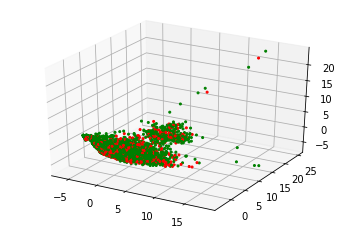

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:, 1], X_reduce[:, 2], s=4, alpha=1,color=colors)
plt.show()

### PCA n = 2 component

In [26]:
pca = PCA(n_components=2)  # Reduce to k=2 dimensions
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

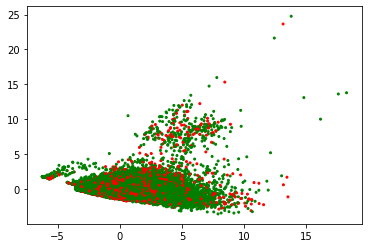

In [42]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_reduce[:,0], X_reduce[:, 1], s=4,color=colors)
plt.show()

### Pairplot

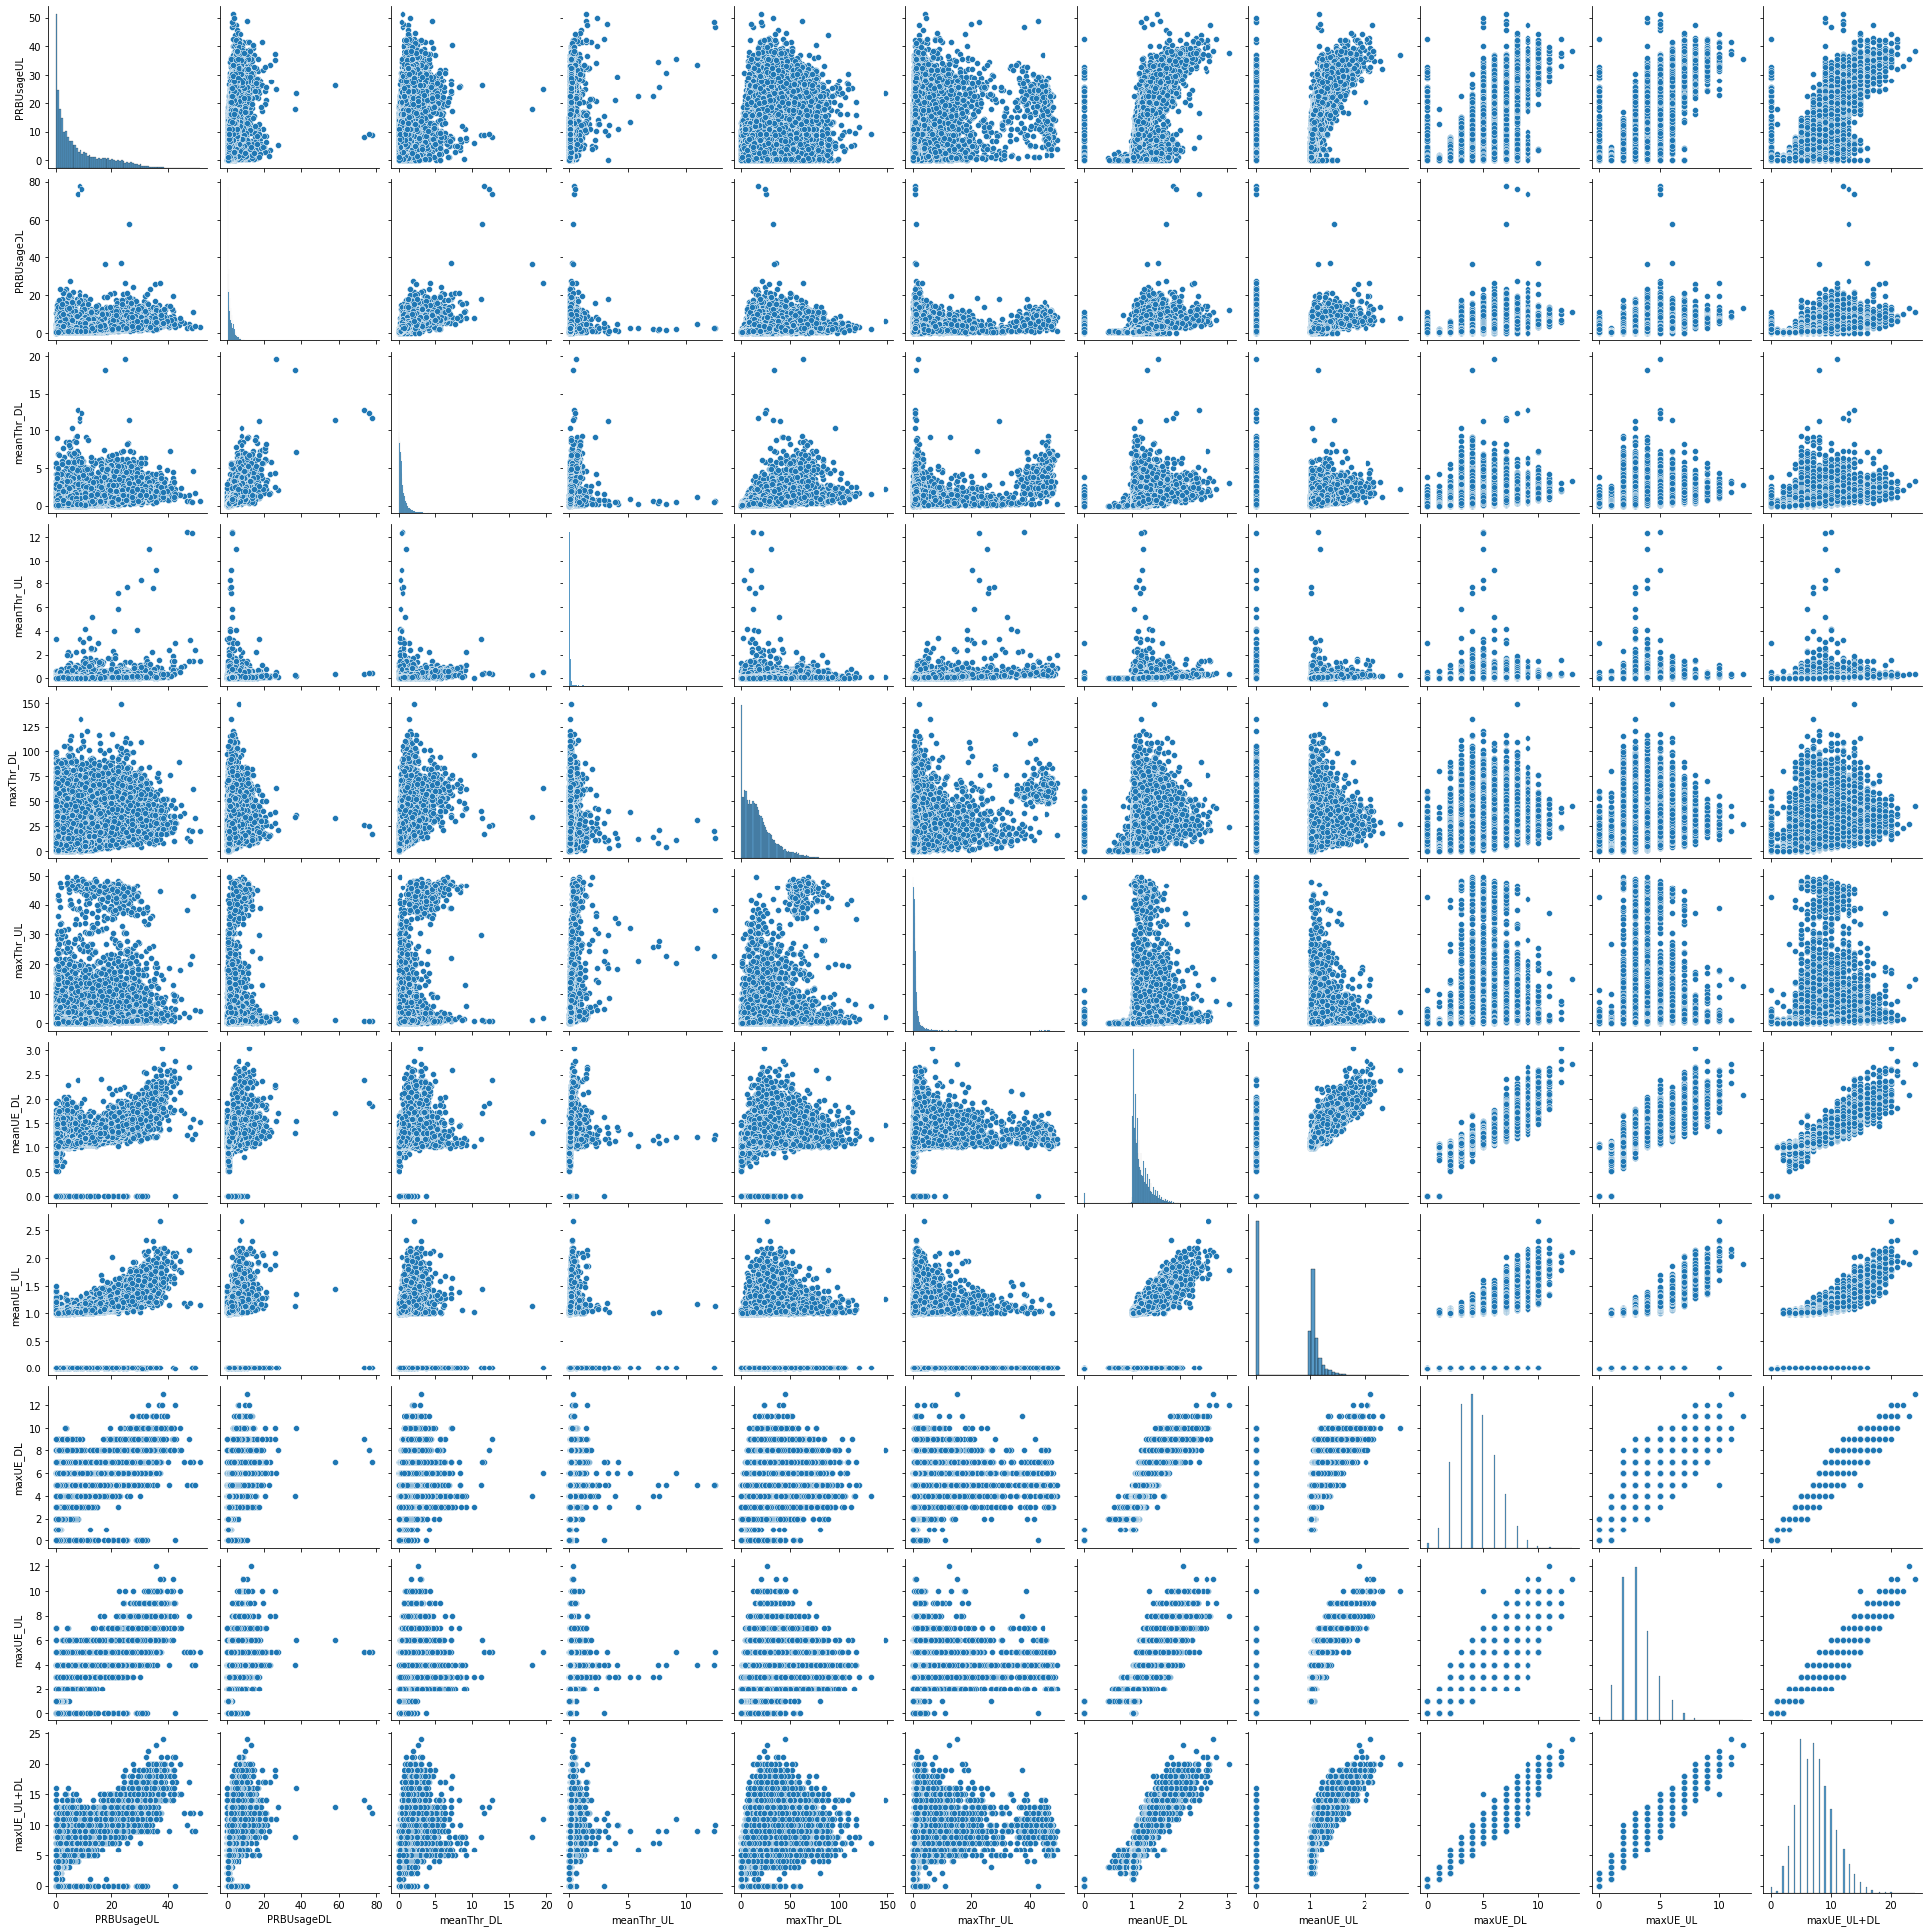

In [43]:
import seaborn as sns
sns.pairplot(X)

### Correlation Matrix

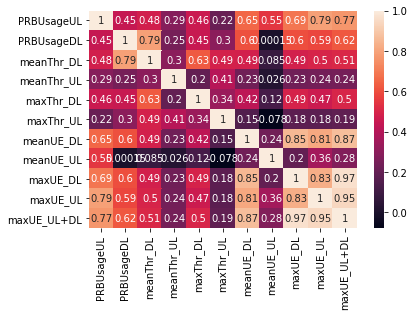

In [48]:
corrMatrix = X.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### tSNE

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 29523 samples in 0.063s...
[t-SNE] Computed neighbors for 29523 samples in 1.980s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29523
[t-SNE] Computed conditional probabilities for sample 2000 / 29523
[t-SNE] Computed conditional probabilities for sample 3000 / 29523
[t-SNE] Computed conditional probabilities for sample 4000 / 29523
[t-SNE] Computed conditional probabilities for sample 5000 / 29523
[t-SNE] Computed conditional probabilities for sample 6000 / 29523
[t-SNE] Computed conditional probabilities for sample 7000 / 29523
[t-SNE] Computed conditional probabilities for sample 8000 / 29523
[t-SNE] Computed conditional probabilities for sample 9000 / 29523
[t-SNE] Computed conditional probabilities for sample 10000 / 29523
[t-SNE] Computed conditional probabilities for sample 11000 / 29523
[t-SNE] Computed conditional probabilities for sample 12000 / 29523
[t-SNE] Computed conditional probabilities for sa

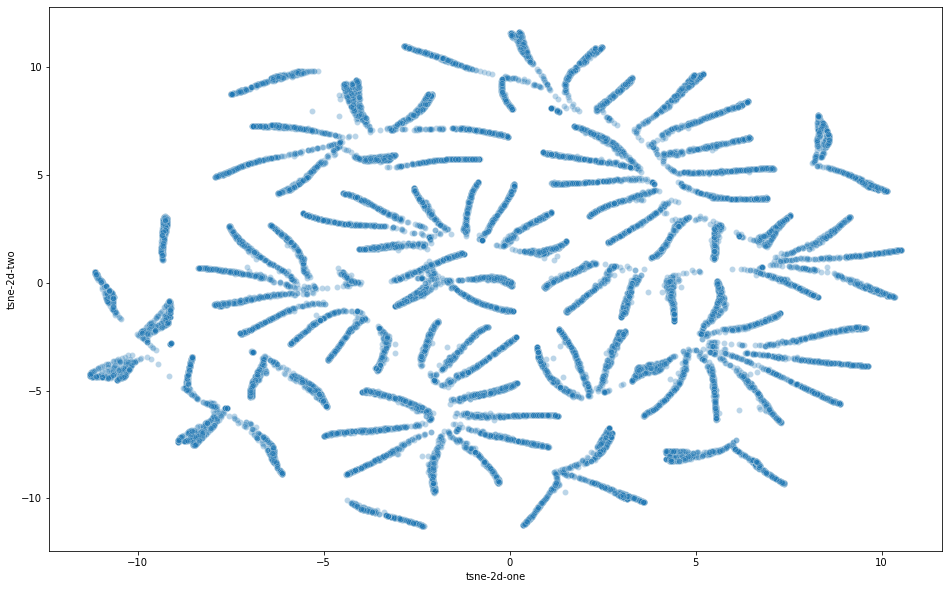

In [58]:
df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

### MDA

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

mda = LinearDiscriminantAnalysis(n_components=1)
mda.fit(X_train, y_train)
X_train_mda1 = mda.transform(X_train)
X_test_mda1 = mda.transform(X_validation)

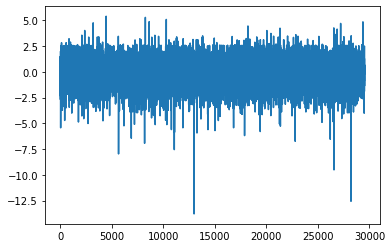

In [68]:
fig, ax = plt.subplots()
plt.plot(X_train_mda1)
plt.show()